In [108]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [109]:
# Load each input type from its respective Caliper folder
tk_random = th.Thicket.from_caliperreader(glob("cali_random/*.cali"))
tk_sorted = th.Thicket.from_caliperreader(glob("cali_sorted/*.cali"))
tk_reverse = th.Thicket.from_caliperreader(glob("cali_reverse/*.cali"))
tk_onepercent = th.Thicket.from_caliperreader(glob("cali_onepercent/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 60/60 [00:02<00:00, 28.31it/s]


In [110]:
# Combine data from each thicket into a dictionary for easier access
tk_dict = {
    "Random": tk_random,
    "Sorted": tk_sorted,
    "ReverseSorted": tk_reverse,
    "1PercentPerturbed": tk_onepercent
}

# Define a function to process each Thicket and extract performance data
def extract_performance_data(thicket, input_type):
    thicket.metadata_column_to_perfdata("num_procs")
    thicket.metadata_column_to_perfdata("input_size")
    # Reset index for easier access by metadata columns and add input type for distinction
    df = thicket.dataframe.reset_index().set_index(["node", "num_procs", "input_size"]).sort_index()
    df["input_type"] = input_type
    return df

# Gather data from each Thicket into a single DataFrame
dataframes = []
for input_type, tk in tk_dict.items():
    dataframes.append(extract_performance_data(tk, input_type))

# Concatenate all dataframes along rows
combined_df = pd.concat(dataframes)

print(combined_df.columns)

# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
# array_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
# array_types = ["Random", "Sorted, ReverseSorted, 1PercentPerturbed"]

Index(['profile', 'nid', 'spot.channel', 'Min time/rank', 'Max time/rank',
       'Avg time/rank', 'Total time', 'Variance time/rank', 'Calls/rank (min)',
       'Calls/rank (avg)', 'Calls/rank (max)', 'Calls/rank (total)',
       'Min time/rank (exc)', 'Max time/rank (exc)', 'Avg time/rank (exc)',
       'Total time (exc)', 'name', 'input_type'],
      dtype='object')


In [111]:
# # Updated extract_and_plot_times function
# def extract_and_plot_times(array_size, array_type, combined_df):
#     # Dictionary of timing sections to analyze
#     timing_sections = {
#         'whole_program': 'whole_computation',
#         'initialization': 'data_init_runtime',
#         'communication': {
#             'main': 'comm',
#             'small': 'comm_small',
#             'large': 'comm_large'
#         },
#         'computation': {
#             'main': 'comp',
#             'small': 'comp_small',
#             'large': 'comp_large'
#         },
#         'validation': 'correctness_check'
#     }
    
#     def plot_timing_section(section_name, marker_name, processes):
#         times = {
#             'min': combined_df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Min time/rank'],
#             'avg': combined_df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Avg time/rank'],
#             'max': combined_df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Max time/rank']
#         }
        
#         min_times = []
#         avg_times = []
#         max_times = []
        
#         for num_proc in processes:
#             try:
#                 min_times.append(times['min'].loc[(num_proc, array_size, array_type, marker_name)])
#                 avg_times.append(times['avg'].loc[(num_proc, array_size, array_type, marker_name)])
#                 max_times.append(times['max'].loc[(num_proc, array_size, array_type, marker_name)])
#             except KeyError as e:
#                 print(f"Missing data for process count {num_proc} in {marker_name}")
#                 continue
            
#         plt.figure(figsize=(12, 8))
#         plt.plot(processes[:len(min_times)], min_times, marker='o', linestyle='-', color='r', label='Min Time')
#         plt.plot(processes[:len(avg_times)], avg_times, marker='o', linestyle='-', color='b', label='Avg Time')
#         plt.plot(processes[:len(max_times)], max_times, marker='o', linestyle='-', color='y', label='Max Time')
        
#         array_type_name = {1: 'Random', 2: 'Sorted', 3: 'ReverseSorted', 4: '1PercentPerturbed'}.get(array_type, str(array_type))
#         plt.title(f'{section_name} Time vs. Processes\nArray Size: {array_size}, Type: {array_type_name}')
#         plt.xlabel('Number of Processes')
#         plt.ylabel('Time (seconds)')
#         plt.legend()
#         plt.grid(True)
#         plt.show()
        
#         return min_times, avg_times, max_times

#     # Plot main program timing
#     main_times = plot_timing_section('Whole Program', timing_sections['whole_program'], processes)
    
#     # Plot initialization timing
#     init_times = plot_timing_section('Data Initialization', timing_sections['initialization'], processes)
    
#     # Plot communication timings
#     comm_times = {
#         'main': plot_timing_section('Total Communication', timing_sections['communication']['main'], processes),
#         'small': plot_timing_section('Small Communication', timing_sections['communication']['small'], processes),
#         'large': plot_timing_section('Large Communication', timing_sections['communication']['large'], processes)
#     }
    
#     # Plot computation timings
#     comp_times = {
#         'main': plot_timing_section('Total Computation', timing_sections['computation']['main'], processes),
#         'small': plot_timing_section('Small Computation', timing_sections['computation']['small'], processes),
#         'large': plot_timing_section('Large Computation', timing_sections['computation']['large'], processes)
#     }
    
#     # Plot validation timing
#     validation_times = plot_timing_section('Correctness Check', timing_sections['validation'], processes)
    
#     # Create a comparison plot of major components
#     plt.figure(figsize=(12, 8))
#     components = ['Communication', 'Computation', 'Initialization', 'Validation']
    
#     array_type_name = {1: 'Random', 2: 'Sorted', 3: 'ReverseSorted', 4: '1PercentPerturbed'}.get(array_type, str(array_type))
    
#     plt.plot(processes, comm_times['main'][1], marker='o', label='Communication')
#     plt.plot(processes, comp_times['main'][1], marker='s', label='Computation')
#     plt.plot(processes, init_times[1], marker='^', label='Initialization')
#     plt.plot(processes, validation_times[1], marker='v', label='Validation')
    
#     plt.title(f'Component Time Comparison vs. Processes\nArray Size: {array_size}, Type: {array_type_name}')
#     plt.xlabel('Number of Processes')
#     plt.ylabel('Average Time (seconds)')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Call the function for a specific array size and type
# # extract_and_plot_times(65536, "1PercentPerturbed", combined_df)
# # extract_and_plot_times(4194304, "Random", combined_df)
# extract_and_plot_times(268435456, "1PercentPerturbed", combined_df)





/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update 

Missing data for process count 512 in Random
Missing data for process count 1024 in Random
Missing data for process count 512 in Sorted
Missing data for process count 1024 in Sorted
Missing data for process count 512 in ReverseSorted
Missing data for process count 1024 in ReverseSorted
Missing data for process count 512 in 1PercentPerturbed
Missing data for process count 1024 in 1PercentPerturbed


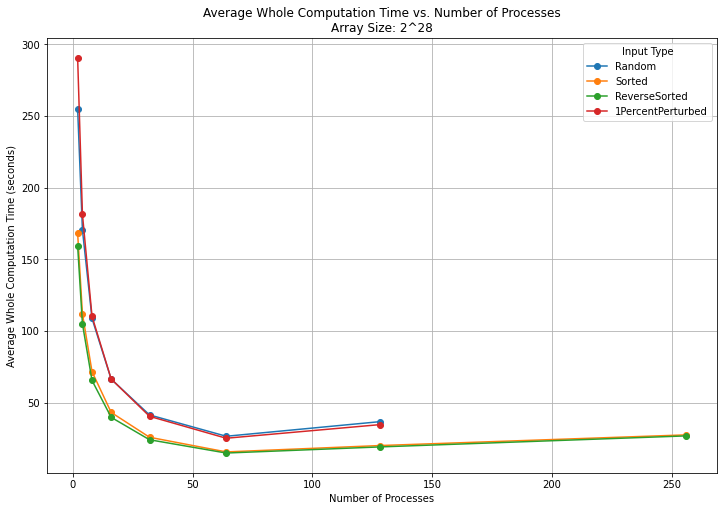

Missing data for process count 2 in Random
Missing data for process count 4 in Random
Missing data for process count 8 in Random
Missing data for process count 16 in Random
Missing data for process count 32 in Random
Missing data for process count 64 in Random
Missing data for process count 128 in Random
Missing data for process count 256 in Random
Missing data for process count 512 in Random
Missing data for process count 1024 in Random
Missing data for process count 2 in Sorted
Missing data for process count 4 in Sorted
Missing data for process count 8 in Sorted
Missing data for process count 16 in Sorted
Missing data for process count 32 in Sorted
Missing data for process count 64 in Sorted
Missing data for process count 128 in Sorted
Missing data for process count 256 in Sorted
Missing data for process count 512 in Sorted
Missing data for process count 1024 in Sorted
Missing data for process count 2 in ReverseSorted
Missing data for process count 4 in ReverseSorted
Missing data for

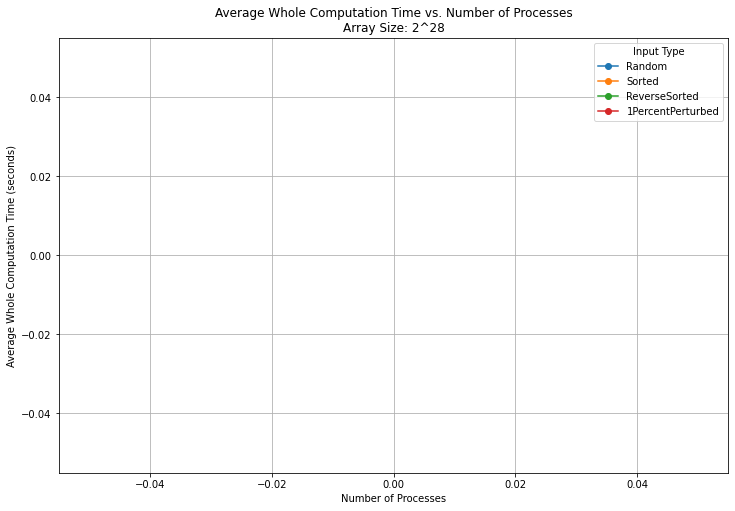

Missing data for process count 2 in Random
Missing data for process count 4 in Random
Missing data for process count 8 in Random
Missing data for process count 16 in Random
Missing data for process count 32 in Random
Missing data for process count 64 in Random
Missing data for process count 128 in Random
Missing data for process count 256 in Random
Missing data for process count 512 in Random
Missing data for process count 1024 in Random
Missing data for process count 2 in Sorted
Missing data for process count 4 in Sorted
Missing data for process count 8 in Sorted
Missing data for process count 16 in Sorted
Missing data for process count 32 in Sorted
Missing data for process count 64 in Sorted
Missing data for process count 128 in Sorted
Missing data for process count 256 in Sorted
Missing data for process count 512 in Sorted
Missing data for process count 1024 in Sorted
Missing data for process count 2 in ReverseSorted
Missing data for process count 4 in ReverseSorted
Missing data for

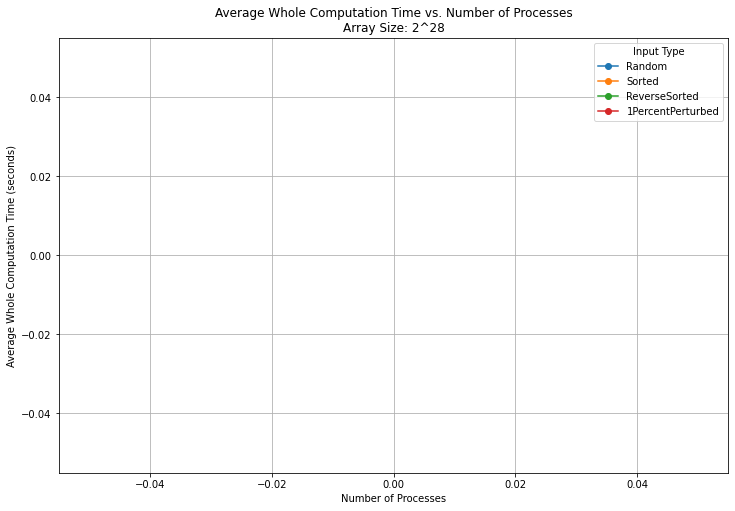

In [112]:
# MAIN STRONG SCALING

# import matplotlib.pyplot as plt
# import pandas as pd
# import thicket as th
# from glob import glob

# # Load each input type from its respective Caliper folder
# tk_random = th.Thicket.from_caliperreader(glob("cali_random/*.cali"))
# tk_sorted = th.Thicket.from_caliperreader(glob("cali_sorted/*.cali"))
# tk_reverse = th.Thicket.from_caliperreader(glob("cali_reverse/*.cali"))
# tk_onepercent = th.Thicket.from_caliperreader(glob("cali_onepercent/*.cali"))

# # Combine data from each thicket into a dictionary for easier access
# tk_dict = {
#     "Random": tk_random,
#     "Sorted": tk_sorted,
#     "ReverseSorted": tk_reverse,
#     "1PercentPerturbed": tk_onepercent
# }

# Function to process each Thicket and extract performance data
def extract_performance_data(thicket, input_type):
    thicket.metadata_column_to_perfdata("num_procs")
    thicket.metadata_column_to_perfdata("input_size")
    # Reset index for easier access by metadata columns and add input type for distinction
    df = thicket.dataframe.reset_index().set_index(["node", "num_procs", "input_size"]).sort_index()
    df["input_type"] = input_type
    return df

# Gather data from each Thicket into a single DataFrame
dataframes = []
for input_type, tk in tk_dict.items():
    dataframes.append(extract_performance_data(tk, input_type))

# Concatenate all dataframes along rows
combined_df = pd.concat(dataframes)

# Define a function to plot average whole computation time for each input type
def plot_whole_computation_time(combined_df, processes, array_size=67108864):
    plt.figure(figsize=(12, 8))

    # Loop through each input type and plot whole computation time
    for input_type in combined_df['input_type'].unique():
        avg_times = []

        # Extract whole computation average times for each process count for the specified array size
        for num_proc in processes:
            try:
                avg_time = combined_df.loc[(slice(None), num_proc, array_size), :].query("input_type == @input_type & name == 'whole_computation'")['Avg time/rank']
                avg_times.append(avg_time.mean())  # Calculate the average over all relevant entries
            except KeyError:
                print(f"Missing data for process count {num_proc} in {input_type}")
                avg_times.append(None)

        plt.plot(processes[:len(avg_times)], avg_times, marker='o', label=input_type)

    # Plot formatting
    plt.title('Average Whole Computation Time vs. Number of Processes\nArray Size: 2^28')
    plt.xlabel('Number of Processes')
    plt.ylabel('Average Whole Computation Time (seconds)')
    plt.legend(title='Input Type')
    plt.grid(True)
    plt.show()

# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Call the function to plot the data for array size 2^28
plot_whole_computation_time(combined_df, processes, array_size=268435456)
plot_whole_computation_time(combined_df, processes, array_size=2^26)
plot_whole_computation_time(combined_df, processes, array_size=2^24)



/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update 

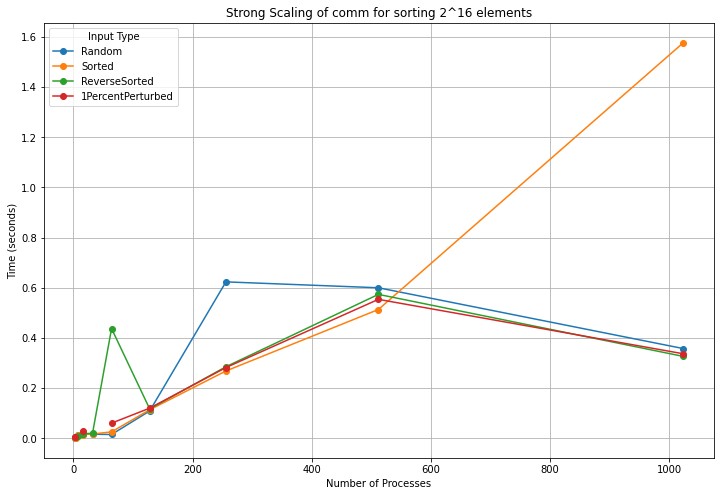

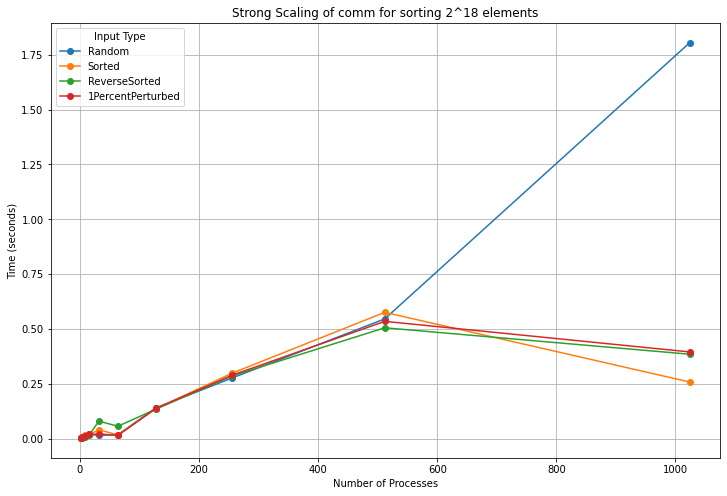

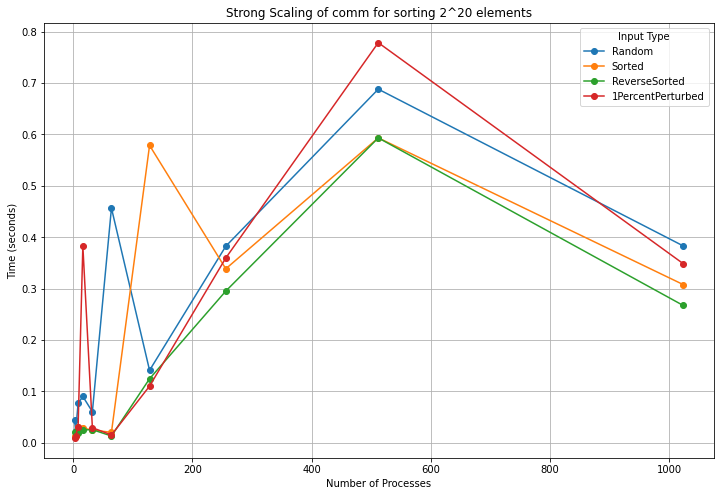

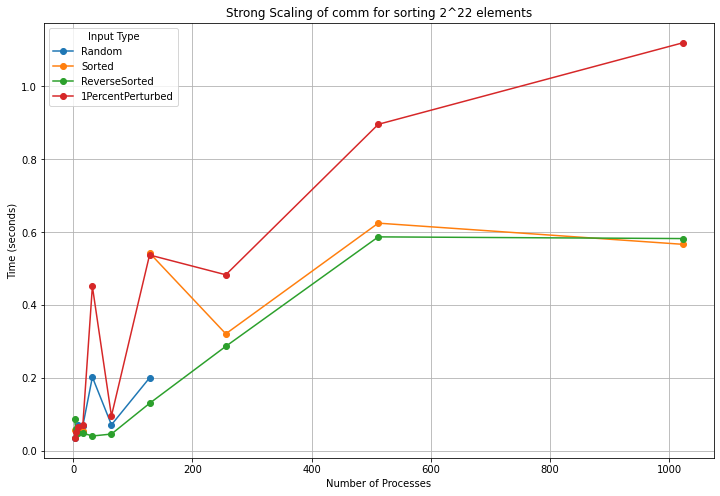

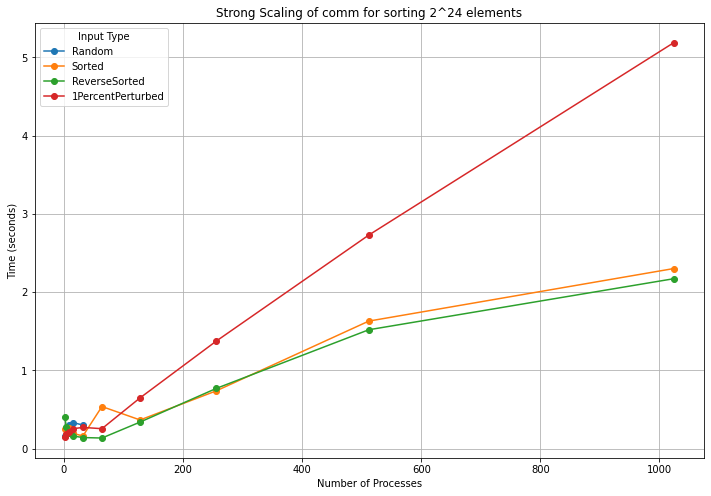

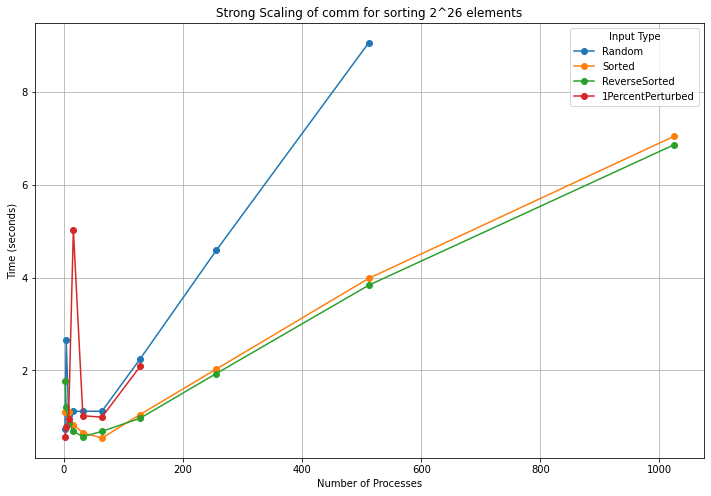

Missing data for process count 512 in Random
Missing data for process count 1024 in Random
Missing data for process count 512 in Sorted
Missing data for process count 1024 in Sorted
Missing data for process count 512 in ReverseSorted
Missing data for process count 1024 in ReverseSorted
Missing data for process count 512 in 1PercentPerturbed
Missing data for process count 1024 in 1PercentPerturbed


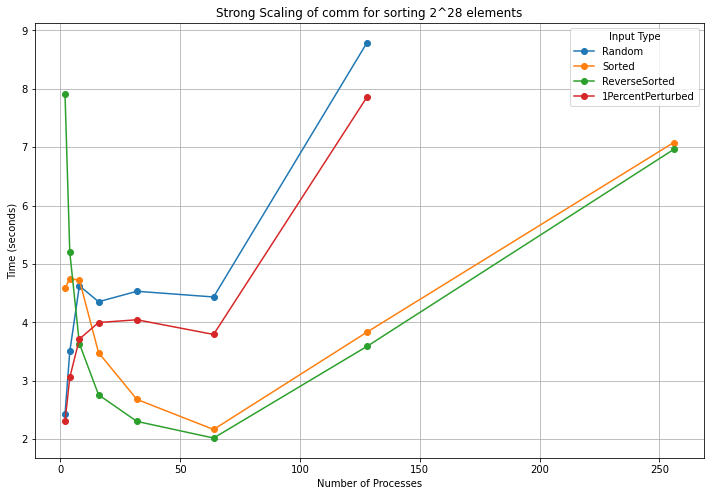

In [113]:
# strong scaling for comm (1st on report)

import math

# Function to process each Thicket and extract performance data
def extract_performance_data(thicket, input_type):
    thicket.metadata_column_to_perfdata("num_procs")
    thicket.metadata_column_to_perfdata("input_size")
    # Reset index for easier access by metadata columns and add input type for distinction
    df = thicket.dataframe.reset_index().set_index(["node", "num_procs", "input_size"]).sort_index()
    df["input_type"] = input_type
    return df

# Gather data from each Thicket into a single DataFrame
dataframes = []
for input_type, tk in tk_dict.items():
    dataframes.append(extract_performance_data(tk, input_type))

# Concatenate all dataframes along rows
combined_df = pd.concat(dataframes)

# Define a function to plot average communication time for each input type
def plot_communication_time(combined_df, processes, array_size=268435456):
    plt.figure(figsize=(12, 8))

    # Loop through each input type and plot communication time
    for input_type in combined_df['input_type'].unique():
        avg_times = []

        # Extract communication average times for each process count for the specified array size
        for num_proc in processes:
            try:
                avg_time = combined_df.loc[(slice(None), num_proc, array_size), :].query("input_type == @input_type & name == 'comm'")['Avg time/rank']
                avg_times.append(avg_time.mean())  # Calculate the average over all relevant entries
            except KeyError:
                print(f"Missing data for process count {num_proc} in {input_type}")
                avg_times.append(None)

        plt.plot(processes[:len(avg_times)], avg_times, marker='o', label=input_type)

    # Plot formatting
    exponent = int(math.log2(array_size))
    plt.title(f'Strong Scaling of comm for sorting 2^{exponent} elements')
#     plt.title('Average Communication Time vs. Number of Processes\nArray Size: 2^28')
    plt.xlabel('Number of Processes')
    plt.ylabel('Time (seconds)')
    plt.legend(title='Input Type')
    plt.grid(True)
    plt.show()

# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Call the function to plot the data for array size
plot_communication_time(combined_df, processes, array_size=65536)
plot_communication_time(combined_df, processes, array_size=262144)
plot_communication_time(combined_df, processes, array_size=1048576)
plot_communication_time(combined_df, processes, array_size=4194304)
plot_communication_time(combined_df, processes, array_size=16777216)
plot_communication_time(combined_df, processes, array_size=67108864)
plot_communication_time(combined_df, processes, array_size=268435456)


/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update 

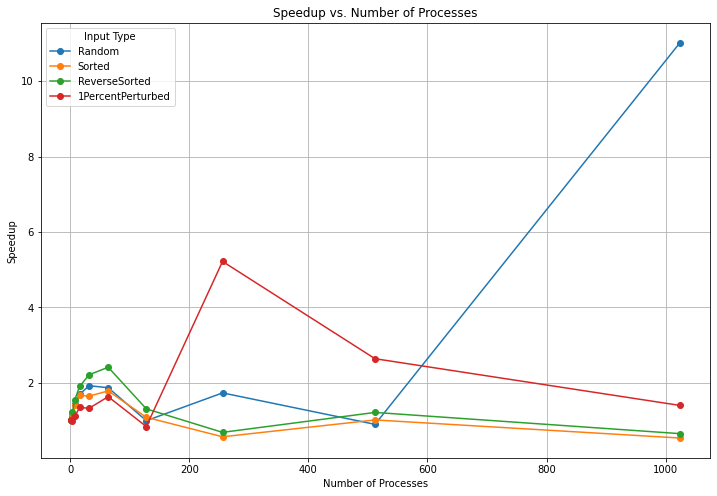

In [114]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import thicket as th
# from glob import glob

# # Load each input type from its respective Caliper folder
# tk_random = th.Thicket.from_caliperreader(glob("cali_random/*.cali"))
# tk_sorted = th.Thicket.from_caliperreader(glob("cali_sorted/*.cali"))
# tk_reverse = th.Thicket.from_caliperreader(glob("cali_reverse/*.cali"))
# tk_onepercent = th.Thicket.from_caliperreader(glob("cali_onepercent/*.cali"))

# # Combine data from each thicket into a dictionary for easier access
# tk_dict = {
#     "Random": tk_random,
#     "Sorted": tk_sorted,
#     "ReverseSorted": tk_reverse,
#     "1PercentPerturbed": tk_onepercent
# }

# Function to process each Thicket and extract performance data
def extract_performance_data(thicket, input_type):
    thicket.metadata_column_to_perfdata("num_procs")
    thicket.metadata_column_to_perfdata("input_size")
    # Reset index for easier access by metadata columns and add input type for distinction
    df = thicket.dataframe.reset_index().set_index(["node", "num_procs", "input_size"]).sort_index()
    df["input_type"] = input_type
    return df

# Gather data from each Thicket into a single DataFrame
dataframes = []
for input_type, tk in tk_dict.items():
    dataframes.append(extract_performance_data(tk, input_type))

# Concatenate all dataframes along rows
combined_df = pd.concat(dataframes)

# Define a function to extract and plot speedup
def plot_speedup(combined_df, processes):
    plt.figure(figsize=(12, 8))

    # Loop through each input type and plot speedup
    for input_type in combined_df['input_type'].unique():
        avg_times = []
        speedup = []

        # Extract average times for each process count
        for num_proc in processes:
            try:
                avg_time = combined_df.loc[(slice(None), num_proc, slice(None)), :].query("input_type == @input_type")['Avg time/rank']
                avg_times.append(avg_time.mean())  # Calculate the average over all relevant entries
            except KeyError:
                print(f"Missing data for process count {num_proc} in {input_type}")
                avg_times.append(None)

        # Calculate speedup relative to the first entry (baseline)
        baseline_time = avg_times[0] if avg_times[0] is not None else 1  # Prevent division by zero
        for time in avg_times:
            if time is not None:
                speedup.append(baseline_time / time)
            else:
                speedup.append(None)

        plt.plot(processes[:len(speedup)], speedup, marker='o', label=input_type)

    # Plot formatting
    plt.title('Speedup vs. Number of Processes')
    plt.xlabel('Number of Processes')
    plt.ylabel('Speedup')
    plt.legend(title='Input Type')
    plt.grid(True)
    plt.show()

# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Call the function to plot the data
plot_speedup(combined_df, processes)


/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update 

Missing data for process count 512 in Random
Missing data for process count 1024 in Random
Missing data for process count 512 in Sorted
Missing data for process count 1024 in Sorted
Missing data for process count 512 in ReverseSorted
Missing data for process count 1024 in ReverseSorted
Missing data for process count 512 in 1PercentPerturbed
Missing data for process count 1024 in 1PercentPerturbed


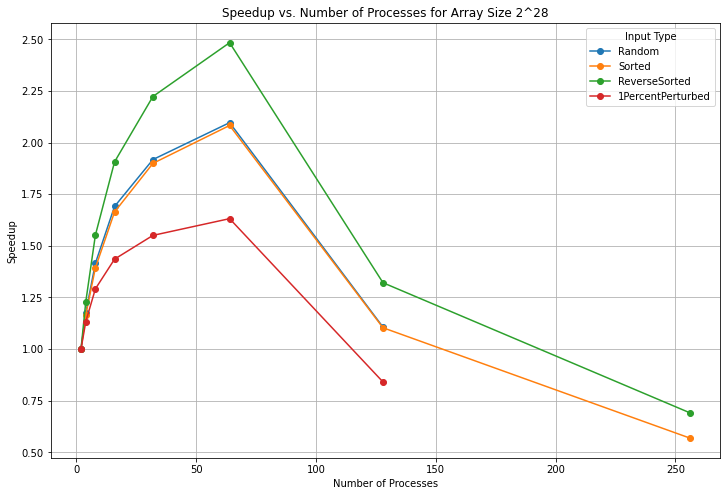

In [115]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import thicket as th
# from glob import glob

# # Load each input type from its respective Caliper folder
# tk_random = th.Thicket.from_caliperreader(glob("cali_random/*.cali"))
# tk_sorted = th.Thicket.from_caliperreader(glob("cali_sorted/*.cali"))
# tk_reverse = th.Thicket.from_caliperreader(glob("cali_reverse/*.cali"))
# tk_onepercent = th.Thicket.from_caliperreader(glob("cali_onepercent/*.cali"))

# # Combine data from each thicket into a dictionary for easier access
# tk_dict = {
#     "Random": tk_random,
#     "Sorted": tk_sorted,
#     "ReverseSorted": tk_reverse,
#     "1PercentPerturbed": tk_onepercent
# }

# Function to process each Thicket and extract performance data
def extract_performance_data(thicket, input_type):
    thicket.metadata_column_to_perfdata("num_procs")
    thicket.metadata_column_to_perfdata("input_size")
    # Reset index for easier access by metadata columns and add input type for distinction
    df = thicket.dataframe.reset_index().set_index(["node", "num_procs", "input_size"]).sort_index()
    df["input_type"] = input_type
    return df

# Gather data from each Thicket into a single DataFrame
dataframes = []
for input_type, tk in tk_dict.items():
    dataframes.append(extract_performance_data(tk, input_type))

# Concatenate all dataframes along rows
combined_df = pd.concat(dataframes)

# Define a function to extract and plot speedup for a specific array size
def plot_speedup(combined_df, processes, array_size=268435456):
    plt.figure(figsize=(12, 8))

    # Loop through each input type and plot speedup
    for input_type in combined_df['input_type'].unique():
        avg_times = []
        speedup = []

        # Extract average times for each process count for the specified array size
        for num_proc in processes:
            try:
                avg_time = combined_df.loc[(slice(None), num_proc, array_size), :].query("input_type == @input_type")['Avg time/rank']
                avg_times.append(avg_time.mean())  # Calculate the average over all relevant entries
            except KeyError:
                print(f"Missing data for process count {num_proc} in {input_type}")
                avg_times.append(None)

        # Set the baseline to the time for 2 processes (if available)
        if avg_times[0] is not None:
            baseline_time = avg_times[0]  # Time for 2 processes
        else:
            print(f"Missing baseline data for input type {input_type}")
            continue

        # Calculate speedup relative to the baseline
        for time in avg_times:
            if time is not None:
                speedup.append(baseline_time / time)
            else:
                speedup.append(None)

        plt.plot(processes[:len(speedup)], speedup, marker='o', label=input_type)

    # Plot formatting
    plt.title('Speedup vs. Number of Processes for Array Size 2^28')
    plt.xlabel('Number of Processes')
    plt.ylabel('Speedup')
    plt.legend(title='Input Type')
    plt.grid(True)
    plt.show()

# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Call the function to plot the data for array size 2^28
plot_speedup(combined_df, processes, array_size=268435456)


/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update 

Missing data for process count 512 in Random
Missing data for process count 1024 in Random
Missing data for process count 512 in Sorted
Missing data for process count 1024 in Sorted
Missing data for process count 512 in ReverseSorted
Missing data for process count 1024 in ReverseSorted
Missing data for process count 512 in 1PercentPerturbed
Missing data for process count 1024 in 1PercentPerturbed


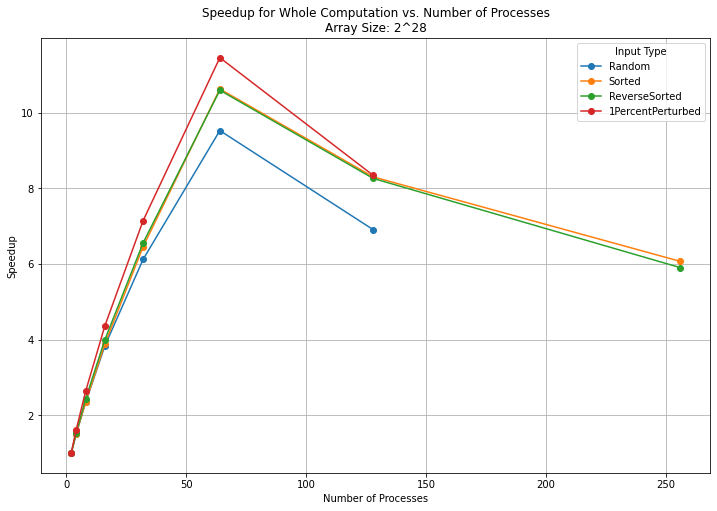

In [116]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import thicket as th
# from glob import glob

# # Load each input type from its respective Caliper folder
# tk_random = th.Thicket.from_caliperreader(glob("cali_random/*.cali"))
# tk_sorted = th.Thicket.from_caliperreader(glob("cali_sorted/*.cali"))
# tk_reverse = th.Thicket.from_caliperreader(glob("cali_reverse/*.cali"))
# tk_onepercent = th.Thicket.from_caliperreader(glob("cali_onepercent/*.cali"))

# # Combine data from each thicket into a dictionary for easier access
# tk_dict = {
#     "Random": tk_random,
#     "Sorted": tk_sorted,
#     "ReverseSorted": tk_reverse,
#     "1PercentPerturbed": tk_onepercent
# }

# Function to process each Thicket and extract performance data
def extract_performance_data(thicket, input_type):
    thicket.metadata_column_to_perfdata("num_procs")
    thicket.metadata_column_to_perfdata("input_size")
    # Reset index for easier access by metadata columns and add input type for distinction
    df = thicket.dataframe.reset_index().set_index(["node", "num_procs", "input_size"]).sort_index()
    df["input_type"] = input_type
    return df

# Gather data from each Thicket into a single DataFrame
dataframes = []
for input_type, tk in tk_dict.items():
    dataframes.append(extract_performance_data(tk, input_type))

# Concatenate all dataframes along rows
combined_df = pd.concat(dataframes)

# Define a function to extract and plot speedup for the whole computation (main) for a specific array size
def plot_main_speedup(combined_df, processes, array_size=67108864):
    plt.figure(figsize=(12, 8))

    # Loop through each input type and plot speedup
    for input_type in combined_df['input_type'].unique():
        main_times = []
        speedup = []

        # Extract main (whole computation) times for each process count
        for num_proc in processes:
            try:
                main_time = combined_df.loc[(slice(None), num_proc, array_size), :].query("input_type == @input_type & name == 'whole_computation'")['Avg time/rank']
                main_times.append(main_time.mean())  # Calculate the average over all relevant entries
            except KeyError:
                print(f"Missing data for process count {num_proc} in {input_type}")
                main_times.append(None)

        # Set the baseline to the time for 2 processes (if available)
        if main_times[0] is not None:
            baseline_time = main_times[0]  # Time for 2 processes
        else:
            print(f"Missing baseline data for input type {input_type}")
            continue

        # Calculate speedup relative to the baseline
        for time in main_times:
            if time is not None:
                speedup.append(baseline_time / time)
            else:
                speedup.append(None)

        plt.plot(processes[:len(speedup)], speedup, marker='o', label=input_type)

    # Plot formatting
    plt.title('Speedup for Whole Computation vs. Number of Processes\nArray Size: 2^28')
    plt.xlabel('Number of Processes')
    plt.ylabel('Speedup')
    plt.legend(title='Input Type')
    plt.grid(True)
    plt.show()

# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Call the function to plot the data for array size 2^26
plot_main_speedup(combined_df, processes, array_size=268435456)


/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column num_procs already exists. Set 'overwrite=True' to force update the column.
  warnings.warn(
/scratch/group/csce435-f24/thicket/thicket/thicket.py:634: UserWarning: Column input_size already exists. Set 'overwrite=True' to force update 

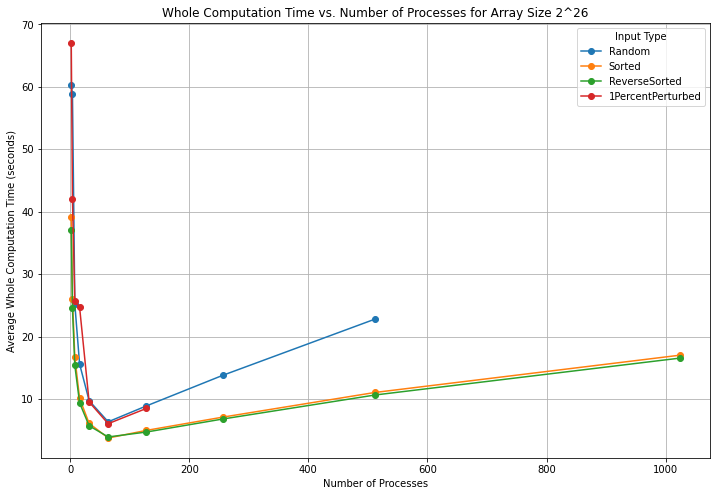

In [117]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import thicket as th
# from glob import glob

# # Load each input type from its respective Caliper folder
# tk_random = th.Thicket.from_caliperreader(glob("cali_random/*.cali"))
# tk_sorted = th.Thicket.from_caliperreader(glob("cali_sorted/*.cali"))
# tk_reverse = th.Thicket.from_caliperreader(glob("cali_reverse/*.cali"))
# tk_onepercent = th.Thicket.from_caliperreader(glob("cali_onepercent/*.cali"))

# # Combine data from each thicket into a dictionary for easier access
# tk_dict = {
#     "Random": tk_random,
#     "Sorted": tk_sorted,
#     "ReverseSorted": tk_reverse,
#     "1PercentPerturbed": tk_onepercent
# }

# Function to process each Thicket and extract performance data
def extract_performance_data(thicket, input_type):
    thicket.metadata_column_to_perfdata("num_procs")
    thicket.metadata_column_to_perfdata("input_size")
    # Reset index for easier access by metadata columns and add input type for distinction
    df = thicket.dataframe.reset_index().set_index(["node", "num_procs", "input_size"]).sort_index()
    df["input_type"] = input_type
    return df

# Gather data from each Thicket into a single DataFrame
dataframes = []
for input_type, tk in tk_dict.items():
    dataframes.append(extract_performance_data(tk, input_type))

# Concatenate all dataframes along rows
combined_df = pd.concat(dataframes)

# Define a function to plot whole computation time for each input type for a specific array size
def plot_whole_computation_time(combined_df, processes, array_size=67108864):
    plt.figure(figsize=(12, 8))

    # Loop through each input type and plot whole computation time
    for input_type in combined_df['input_type'].unique():
        whole_computation_times = []

        # Extract whole computation times for each process count for the specified array size
        for num_proc in processes:
            try:
                comp_time = combined_df.loc[(slice(None), num_proc, array_size), :].query("input_type == @input_type & name == 'whole_computation'")['Avg time/rank']
                whole_computation_times.append(comp_time.mean())  # Calculate the average over all relevant entries
            except KeyError:
                print(f"Missing data for process count {num_proc} in {input_type}")
                whole_computation_times.append(None)

        plt.plot(processes[:len(whole_computation_times)], whole_computation_times, marker='o', label=input_type)

    # Plot formatting
    plt.title('Whole Computation Time vs. Number of Processes for Array Size 2^26')
    plt.xlabel('Number of Processes')
    plt.ylabel('Average Whole Computation Time (seconds)')
    plt.legend(title='Input Type')
    plt.grid(True)
    plt.show()

# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Call the function to plot the data for array size 2^26
plot_whole_computation_time(combined_df, processes, array_size=67108864)


Missing data for process count 256 in comm
Missing data for process count 512 in comm
Missing data for process count 1024 in comm
Missing data for process count 512 in comm
Missing data for process count 1024 in comm
Missing data for process count 512 in comm
Missing data for process count 1024 in comm
Missing data for process count 256 in comm
Missing data for process count 512 in comm
Missing data for process count 1024 in comm


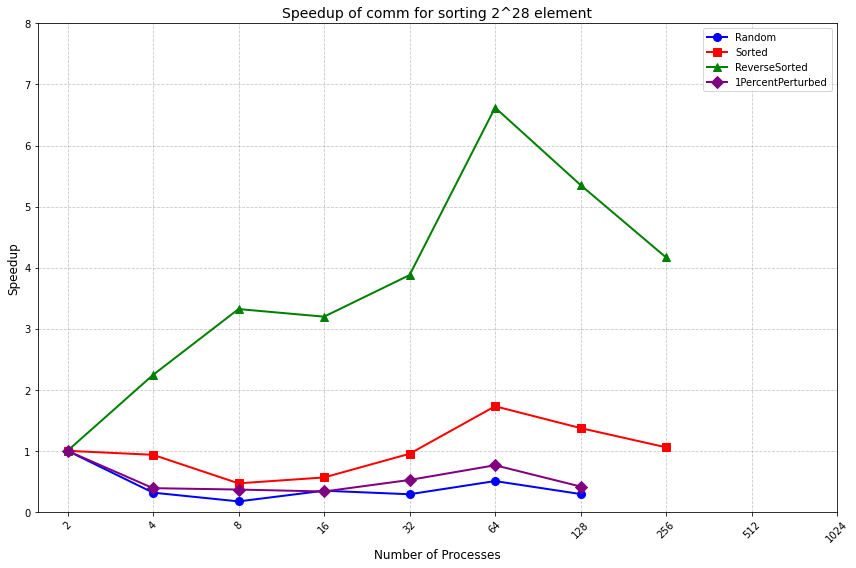

Missing data for process count 1024 in comm
Missing data for process count 256 in comm
Missing data for process count 512 in comm
Missing data for process count 1024 in comm


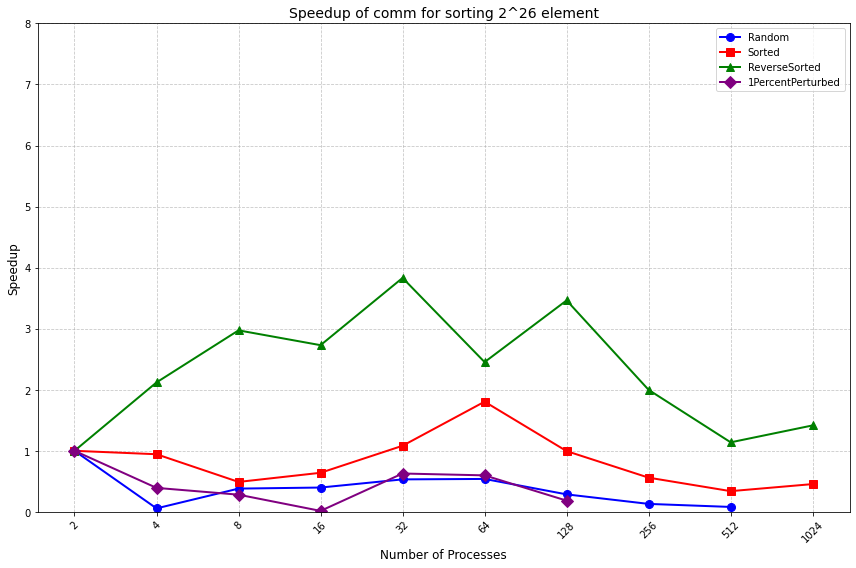

Missing data for process count 64 in comm
Missing data for process count 128 in comm
Missing data for process count 256 in comm
Missing data for process count 512 in comm
Missing data for process count 1024 in comm


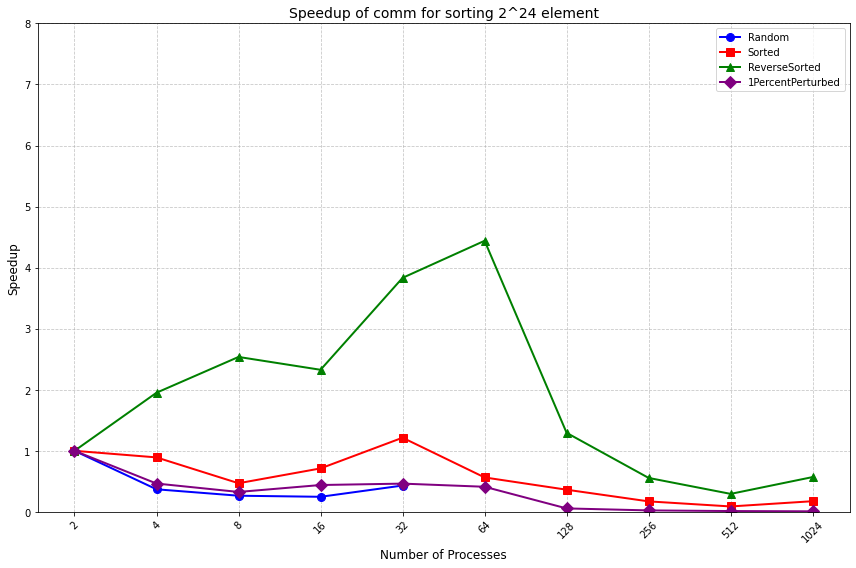

Missing data for process count 256 in comm
Missing data for process count 512 in comm
Missing data for process count 1024 in comm
Missing data for process count 32 in comm
Missing data for process count 64 in comm


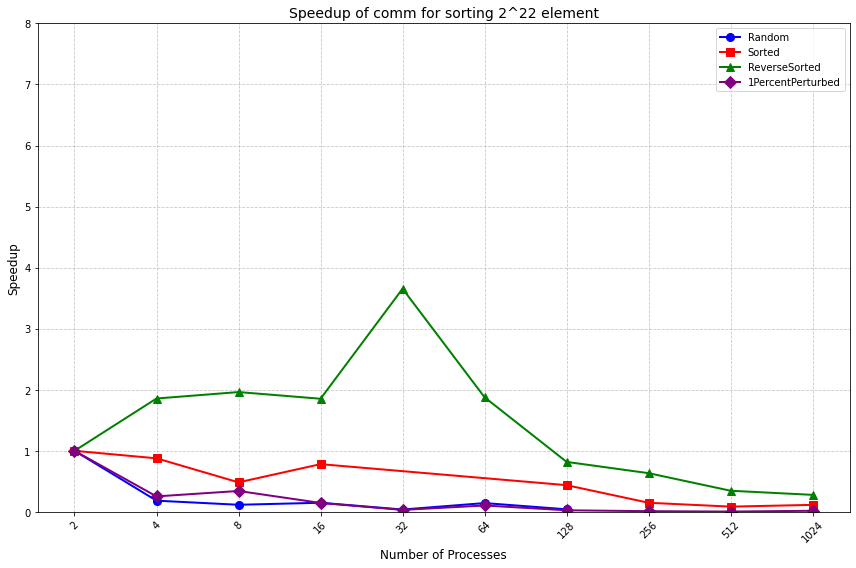

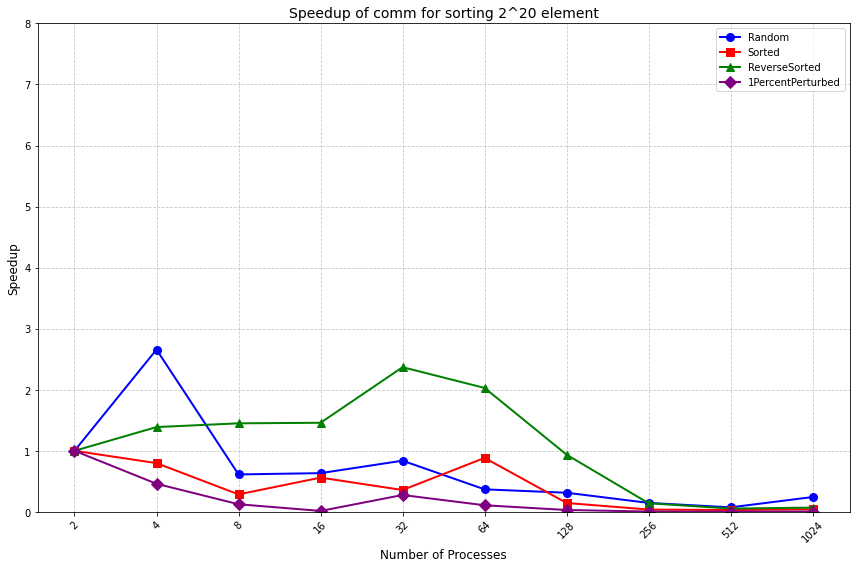

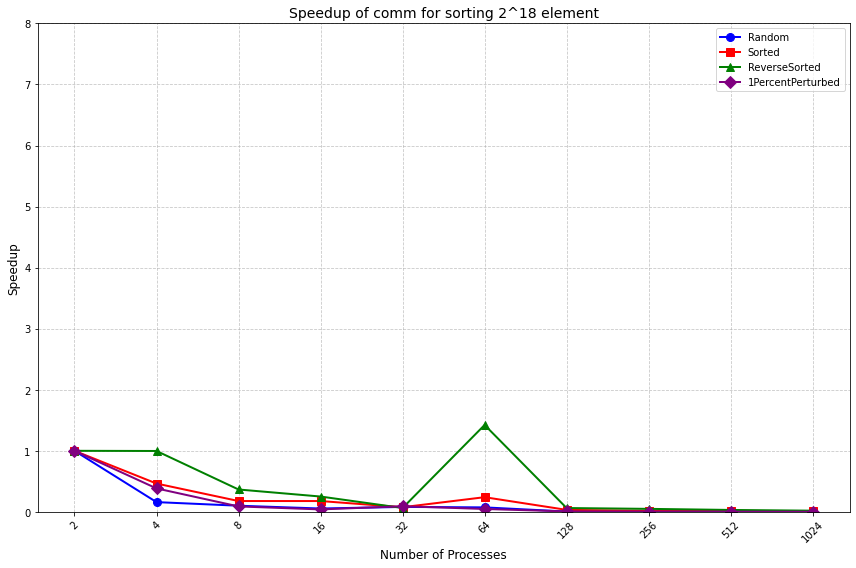

Missing data for process count 4 in comm
Missing data for process count 8 in comm
Missing data for process count 32 in comm


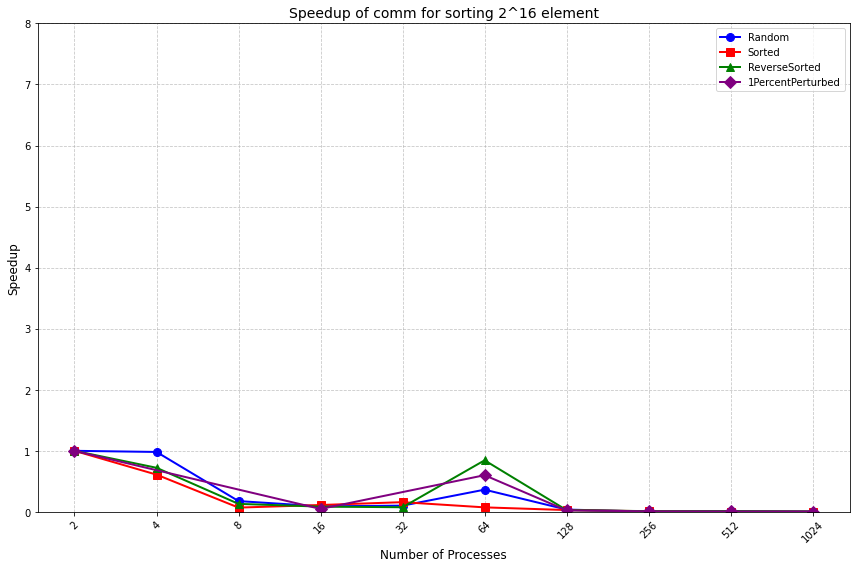

In [118]:
# def plot_communication_speedup(df, processes, timing_sections, comm_type='main', base_processes=2):
#     """
#     Plot speedup graphs for communication time across different processes and input types.
    
#     Parameters:
#     df: pandas DataFrame with performance data
#     processes: list of process counts to plot
#     timing_sections: dictionary containing metric names for different timing sections
#     comm_type: str, type of communication to plot ('main', 'small', or 'large')
#     base_processes: int, number of processes to use as baseline for speedup calculation
#     """
#     plt.figure(figsize=(10, 6))
#     markers = ['o', 's', '^', 'D']  # Different markers for each input type
#     colors = ['blue', 'red', 'green', 'purple']  # Different colors for each input type
    
#     # Get the correct metric name from timing_sections
#     comm_metric = timing_sections['communication'][comm_type]
    
#     # Get unique input types
#     input_types = df['input_type'].unique()
    
#     # Create grouped times dictionary
#     times = {
#         'min': df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Min time/rank'],
#         'avg': df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Avg time/rank'],
#         'max': df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Max time/rank']
#     }
    
#     for idx, input_type in enumerate(input_types):
#         speedups = []
#         valid_processes = []
        
#         # Get baseline time for this input type
#         try:
#             baseline_time = times['avg'].loc[(base_processes, slice(None), input_type, comm_metric)].mean()
            
#             # Calculate speedup for each process count
#             for proc in processes:
#                 try:
#                     avg_time = times['avg'].loc[(proc, slice(None), input_type, comm_metric)].mean()
#                     print(avg_time)
#                     speedup = baseline_time / avg_time
#                     speedups.append(speedup)
#                     valid_processes.append(proc)
#                 except KeyError:
#                     print(f"Missing data for process count {proc} in {comm_metric}")
#                     continue
            
#             # Plot line with markers
#             if valid_processes:  # Only plot if we have data
#                 plt.plot(valid_processes, speedups, 
#                         marker=markers[idx], 
#                         color=colors[idx], 
#                         label=input_type,
#                         linewidth=2,
#                         markersize=8)
                        
#         except KeyError:
#             print(f"Missing baseline data for {input_type} in {comm_metric}")
#             continue

#     # Add ideal speedup line
#     max_proc = max(processes)
#     ideal = np.linspace(base_processes, max_proc, 100)
#     ideal_speedup = ideal / base_processes
#     plt.plot(ideal, ideal_speedup, '--', color='gray', label='Ideal Speedup', alpha=0.5)

#     plt.xlabel('Number of Processes', fontsize=12)
#     plt.ylabel('Speedup', fontsize=12)
#     plt.title(f'Communication Time Speedup - {comm_type.title()} Messages', fontsize=14)
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.legend(fontsize=10)
    
#     # Set x-axis to log scale with appropriate ticks
#     plt.xscale('log', base=2)
#     plt.xticks(processes, [str(p) for p in processes], rotation=45)
    
#     # Set y-axis limits to start from 1
#     plt.ylim(-1, 10)
    
#     plt.tight_layout()
#     return plt

# # Example usage:
# processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
# timing_sections = {
#     'whole_program': 'whole_computation',
#     'initialization': 'data_init_runtime',
#     'communication': {
#         'main': 'comm',
#         'small': 'comm_small',
#         'large': 'comm_large'
#     },
#     'computation': {
#         'main': 'comp',
#         'small': 'comp_small',
#         'large': 'comp_large'
#     },
#     'validation': 'correctness_check'
# }

# # Generate the graph
# plt = plot_communication_speedup(combined_df, processes, timing_sections, 'main')
# plt.savefig('speedup_main.png', bbox_inches='tight', dpi=300)
# plt.show()

def plot_communication_speedup(df, processes, timing_sections, comm_type='main', base_processes=2, input_size=2**28):
    """
    Plot speedup graphs for communication time across different processes for a specific input size and input types.

    Parameters:
    df: pandas DataFrame with performance data
    processes: list of process counts to plot
    timing_sections: dictionary containing metric names for different timing sections
    comm_type: str, type of communication to plot ('main', 'small', or 'large')
    base_processes: int, number of processes to use as baseline for speedup calculation
    input_size: int, specific input size to filter for the plot (default: 2^28)
    """
    plt.figure(figsize=(12, 8))
    markers = ['o', 's', '^', 'D']  # Different markers for each input type
    colors = ['blue', 'red', 'green', 'purple']  # Different colors for each input type
    
    # Get the correct metric name from timing_sections
    comm_metric = timing_sections['communication'][comm_type]
    
    # Get unique input types
    input_types = df['input_type'].unique()
    
    # Create grouped times dictionary
    times = {
        'min': df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Min time/rank'],
        'avg': df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Avg time/rank'],
        'max': df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Max time/rank']
    }
    
    for idx, input_type in enumerate(input_types):
        speedups = []
        valid_processes = []
        
        # Get baseline time for this input type at the specified input size
        try:
            baseline_time = times['avg'].loc[(base_processes, input_size, input_type, comm_metric)]
            
            # Calculate speedup for each process count
            for proc in processes:
                try:
                    avg_time = times['avg'].loc[(proc, input_size, input_type, comm_metric)]
                    speedup = baseline_time / avg_time
                    speedups.append(speedup)
                    valid_processes.append(proc)
                except KeyError:
                    print(f"Missing data for process count {proc} in {comm_metric}")
                    continue
            
            # Plot line with markers
            if valid_processes:  # Only plot if we have data
                plt.plot(valid_processes, speedups, 
                        marker=markers[idx], 
                        color=colors[idx], 
                        label=input_type,
                        linewidth=2,
                        markersize=8)
                        
        except KeyError:
            print(f"Missing baseline data for {input_type} in {comm_metric}")
            continue
            
    exponent = int(math.log2(input_size))
    plt.xlabel('Number of Processes', fontsize=12)
    plt.ylabel('Speedup', fontsize=12)
    plt.title(f'Speedup of comm for sorting 2^{exponent} element', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Set x-axis to log scale with appropriate ticks
    plt.xscale('log', base=2)
    plt.xticks(processes, [str(p) for p in processes], rotation=45)
    
    # Set y-axis limits to start from 1
#     plt.ylim(1, max(speedups) + 1 if speedups else 10)
    plt.ylim(0, 8)
    
    plt.tight_layout()
    return plt

# Example usage:
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
timing_sections = {
    'whole_program': 'whole_computation',
    'initialization': 'data_init_runtime',
    'communication': {
        'main': 'comm',
        'small': 'comm_small',
        'large': 'comm_large'
    },
    'computation': {
        'main': 'comp',
        'small': 'comp_small',
        'large': 'comp_large'
    },
    'validation': 'correctness_check'
}

# Generate the graph
plt = plot_communication_speedup(combined_df, processes, timing_sections, 'main', input_size=2**28)
plt.savefig('speedup_main_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_communication_speedup(combined_df, processes, timing_sections, 'main', input_size=2**26)
plt.savefig('speedup_main_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_communication_speedup(combined_df, processes, timing_sections, 'main', input_size=2**24)
plt.savefig('speedup_main_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_communication_speedup(combined_df, processes, timing_sections, 'main', input_size=2**22)
plt.savefig('speedup_main_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_communication_speedup(combined_df, processes, timing_sections, 'main', input_size=2**20)
plt.savefig('speedup_main_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_communication_speedup(combined_df, processes, timing_sections, 'main', input_size=2**18)
plt.savefig('speedup_main_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_communication_speedup(combined_df, processes, timing_sections, 'main', input_size=2**16)
plt.savefig('speedup_main_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

Missing data for process count 256 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation
Missing data for process count 256 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation


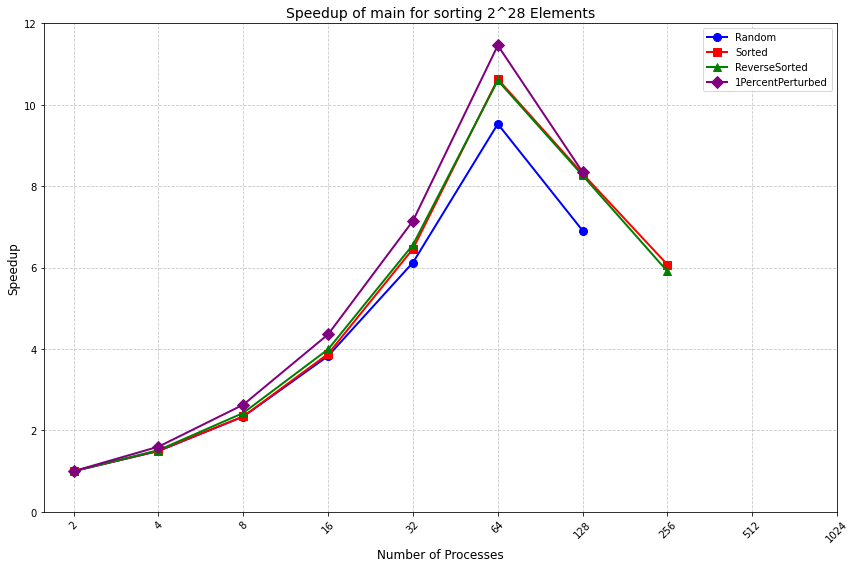

Missing data for process count 1024 in whole_computation
Missing data for process count 256 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation


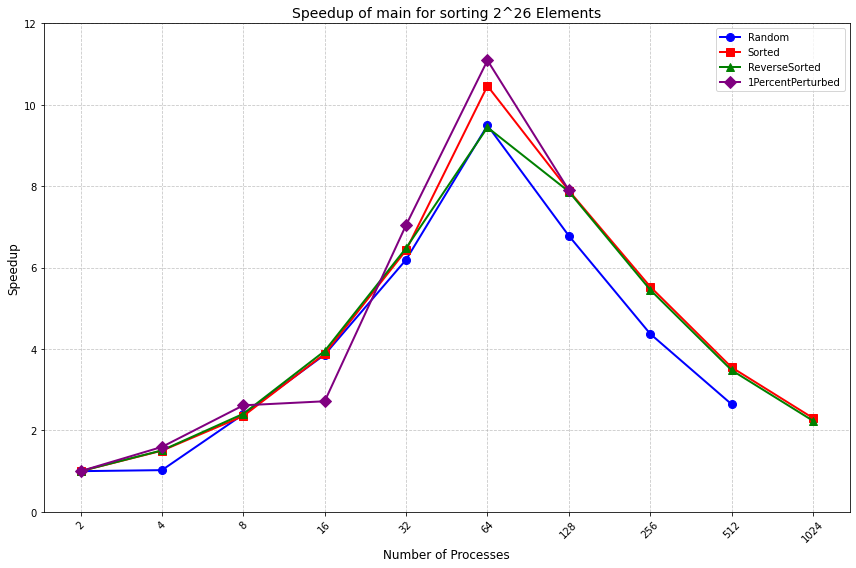

Missing data for process count 64 in whole_computation
Missing data for process count 128 in whole_computation
Missing data for process count 256 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation


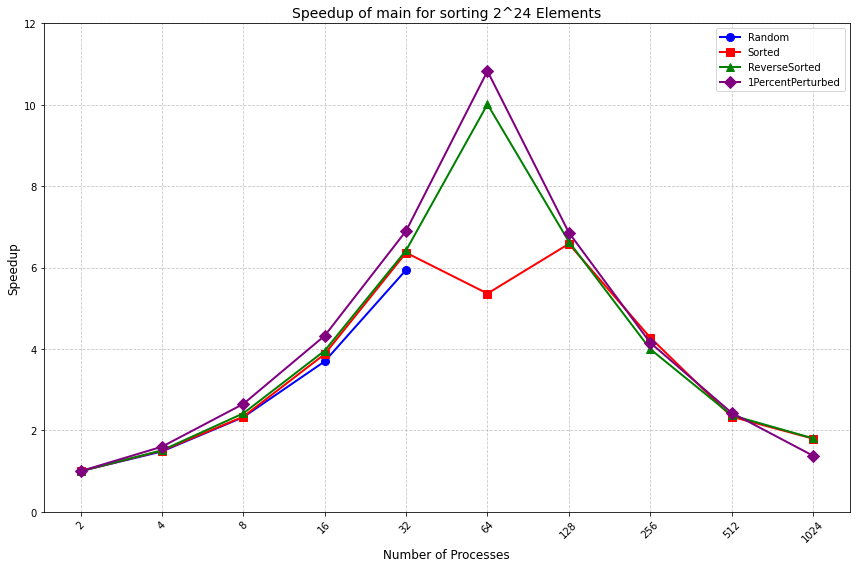

Missing data for process count 256 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation
Missing data for process count 32 in whole_computation
Missing data for process count 64 in whole_computation


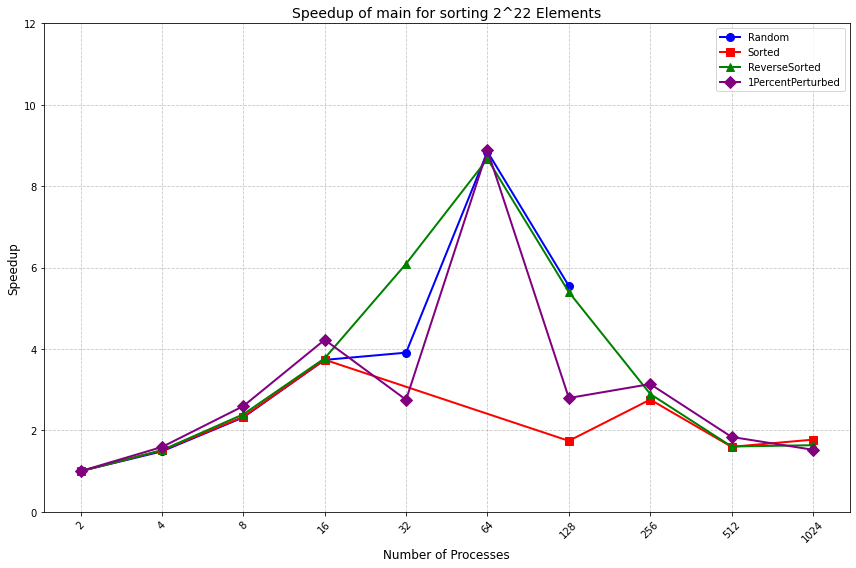

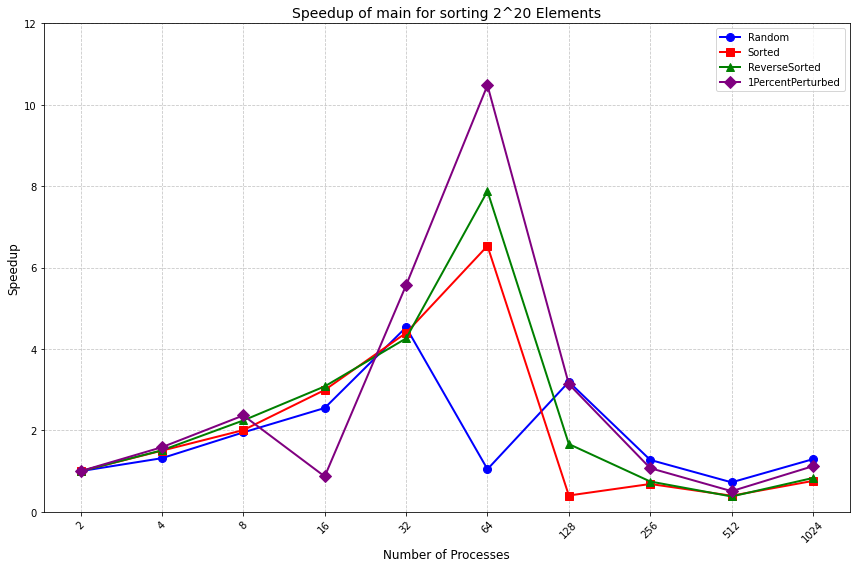

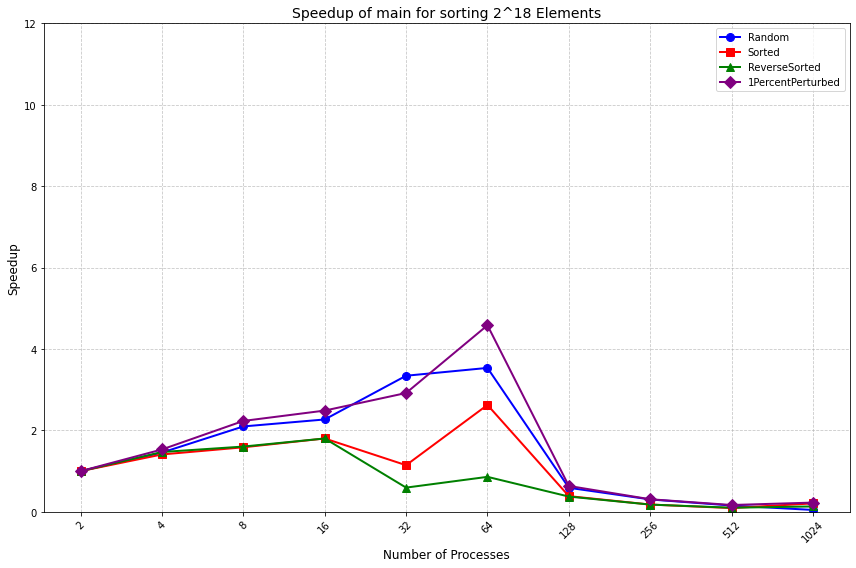

Missing data for process count 4 in whole_computation
Missing data for process count 8 in whole_computation
Missing data for process count 32 in whole_computation


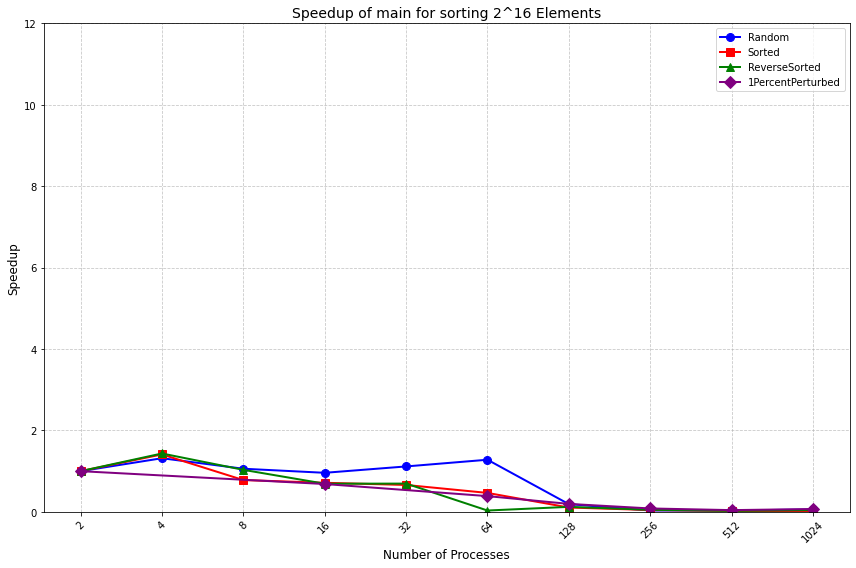

In [131]:
def plot_strong_scaling(df, processes, timing_sections, comm_type='comp_large', base_processes=2, input_size=2**28):
    """
    Plot strong scaling graphs for computation time across different processes for a specific input size and input types.

    Parameters:
    df: pandas DataFrame with performance data
    processes: list of process counts to plot
    timing_sections: dictionary containing metric names for different timing sections
    comm_type: str, type of computation to plot ('comp_large')
    base_processes: int, number of processes to use as baseline for speedup calculation
    input_size: int, specific input size to filter for the plot (default: 2^28)
    """
    plt.figure(figsize=(12, 8))
    markers = ['o', 's', '^', 'D']  # Different markers for each input type
    colors = ['blue', 'red', 'green', 'purple']  # Different colors for each input type

    # Get the correct metric name from timing_sections
#     comp_metric = timing_sections['computation'][comm_type]
    comp_metric = timing_sections['whole_program']
    
    # Get unique input types
    input_types = df['input_type'].unique()
    
    # Create grouped times dictionary
    times = {
        'min': df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Min time/rank'],
        'avg': df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Avg time/rank'],
        'max': df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Max time/rank']
    }
    
    for idx, input_type in enumerate(input_types):
        speedups = []
        valid_processes = []
        
        # Get baseline time for this input type at the specified input size
        try:
            baseline_time = times['avg'].loc[(base_processes, input_size, input_type, comp_metric)]
            
            # Calculate speedup for each process count
            for proc in processes:
                try:
                    avg_time = times['avg'].loc[(proc, input_size, input_type, comp_metric)]
                    speedup = baseline_time / avg_time
                    speedups.append(speedup)
                    valid_processes.append(proc)
                except KeyError:
                    print(f"Missing data for process count {proc} in {comp_metric}")
                    continue
            
            # Plot line with markers
            if valid_processes:  # Only plot if we have data
                plt.plot(valid_processes, speedups, 
                         marker=markers[idx], 
                         color=colors[idx], 
                         label=input_type,
                         linewidth=2,
                         markersize=8)
                        
        except KeyError:
            print(f"Missing baseline data for {input_type} in {comp_metric}")
            continue
            
    exponent = int(math.log2(input_size))
    plt.xlabel('Number of Processes', fontsize=12)
    plt.ylabel('Speedup', fontsize=12)
    plt.title(f'Speedup of main for sorting 2^{exponent} Elements', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Set x-axis to log scale with appropriate ticks
    plt.xscale('log', base=2)
    plt.xticks(processes, [str(p) for p in processes], rotation=45)
    
    # Set y-axis limits to start from 1
    plt.ylim(0, 12)
    
    plt.tight_layout()
    return plt

# Example usage:
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
timing_sections = {
    'whole_program': 'whole_computation',
    'initialization': 'data_init_runtime',
    'communication': {
        'main': 'comm',
        'small': 'comm_small',
        'large': 'comm_large'
    },
    'computation': {
        'main': 'comp',
        'small': 'comp_small',
        'large': 'comp_large'
    },
    'validation': 'correctness_check'
}

# Generate the strong scaling graph for comp_large
plt = plot_strong_scaling(combined_df, processes, timing_sections, comm_type='main', input_size=2**28)
plt.savefig('strong_scaling_comp_large_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_strong_scaling(combined_df, processes, timing_sections, comm_type='main', input_size=2**26)
plt.savefig('strong_scaling_comp_large_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_strong_scaling(combined_df, processes, timing_sections, comm_type='main', input_size=2**24)
plt.savefig('strong_scaling_comp_large_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_strong_scaling(combined_df, processes, timing_sections, comm_type='main', input_size=2**22)
plt.savefig('strong_scaling_comp_large_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_strong_scaling(combined_df, processes, timing_sections, comm_type='main', input_size=2**20)
plt.savefig('strong_scaling_comp_large_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_strong_scaling(combined_df, processes, timing_sections, comm_type='main', input_size=2**18)
plt.savefig('strong_scaling_comp_large_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

plt = plot_strong_scaling(combined_df, processes, timing_sections, comm_type='main', input_size=2**16)
plt.savefig('strong_scaling_comp_large_2^28.png', bbox_inches='tight', dpi=300)
plt.show()

Missing data for process count 256 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation
Missing data for process count 256 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation


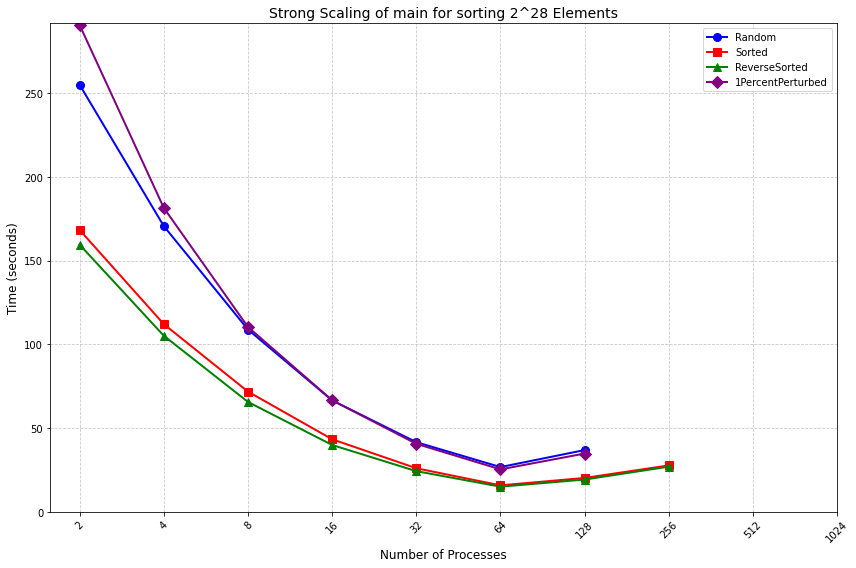

Missing data for process count 1024 in whole_computation
Missing data for process count 256 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation


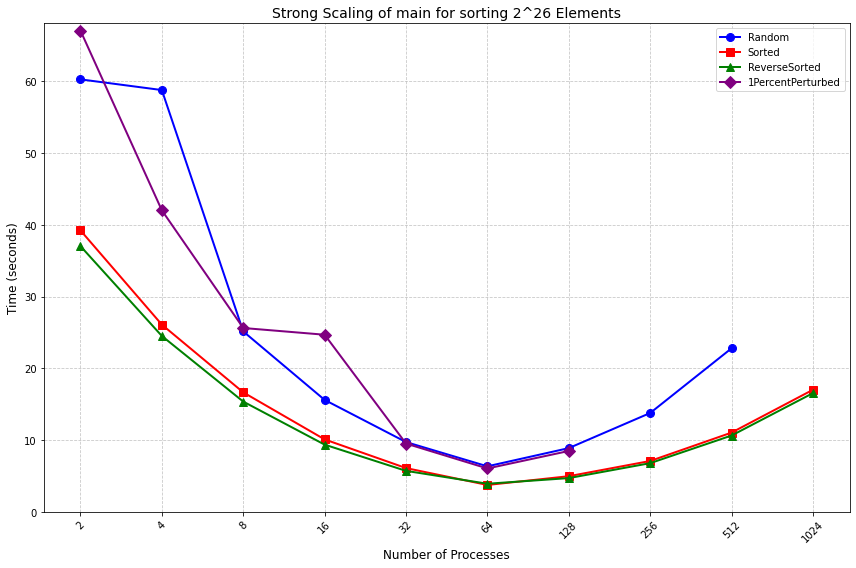

Missing data for process count 64 in whole_computation
Missing data for process count 128 in whole_computation
Missing data for process count 256 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation


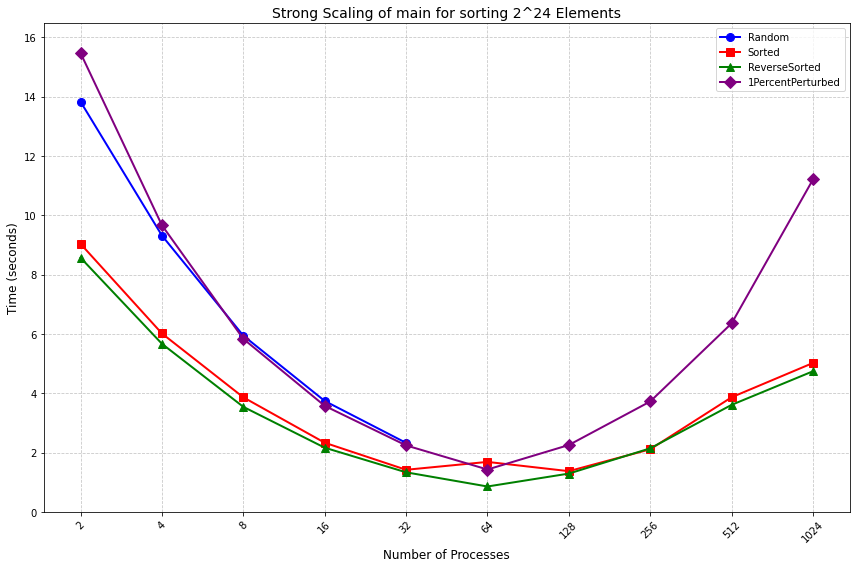

Missing data for process count 256 in whole_computation
Missing data for process count 512 in whole_computation
Missing data for process count 1024 in whole_computation
Missing data for process count 32 in whole_computation
Missing data for process count 64 in whole_computation


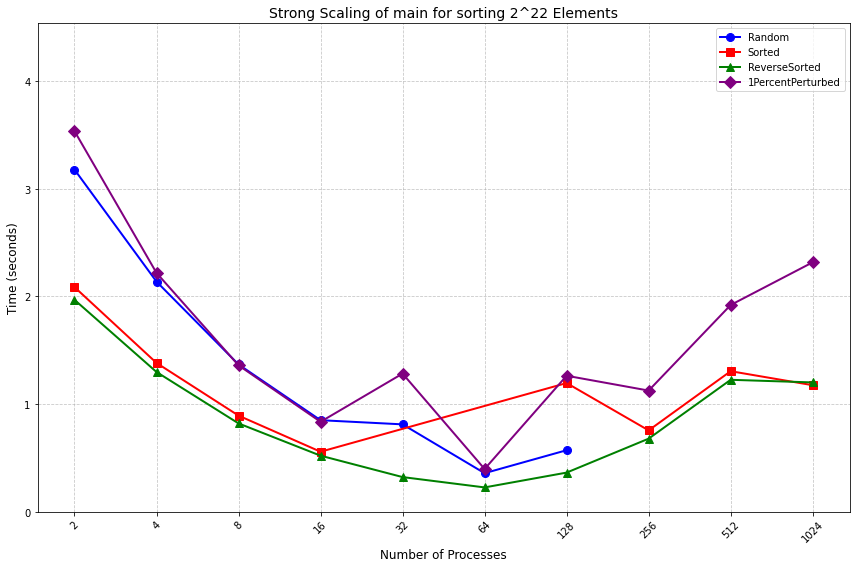

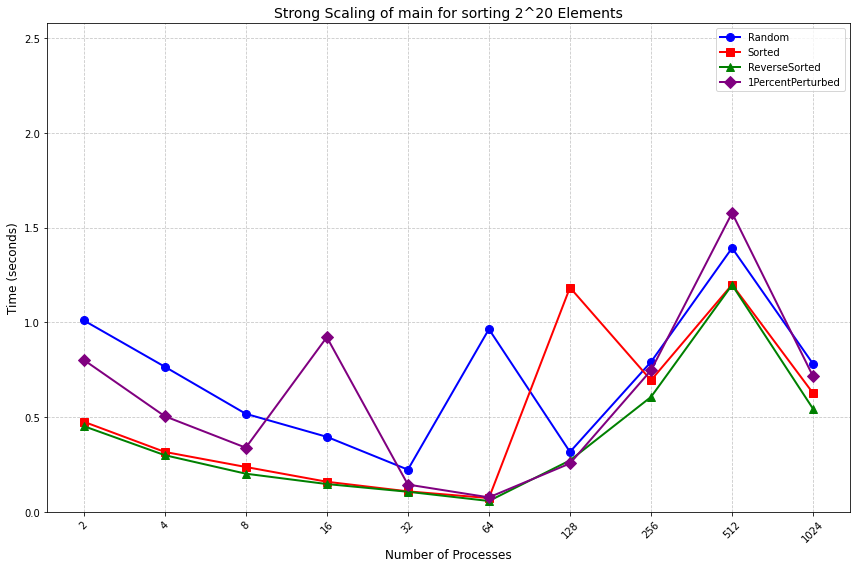

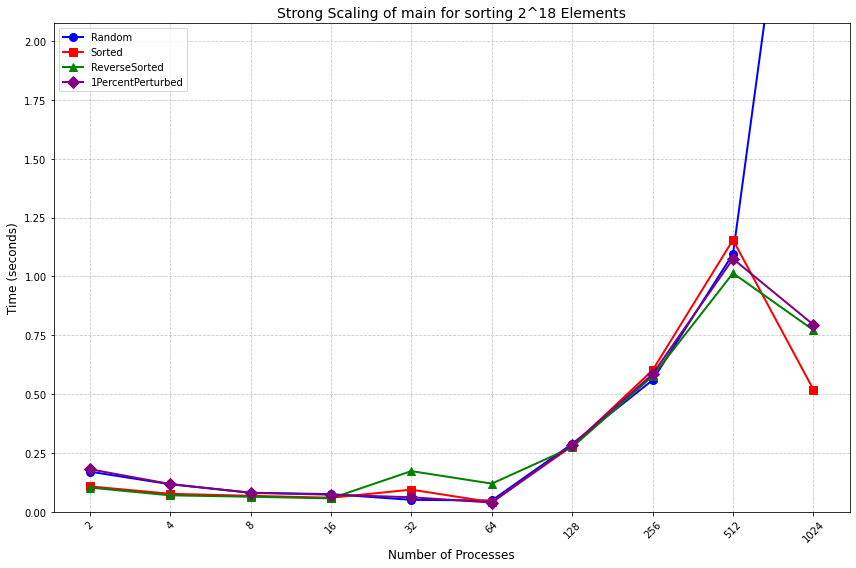

Missing data for process count 4 in whole_computation
Missing data for process count 8 in whole_computation
Missing data for process count 32 in whole_computation


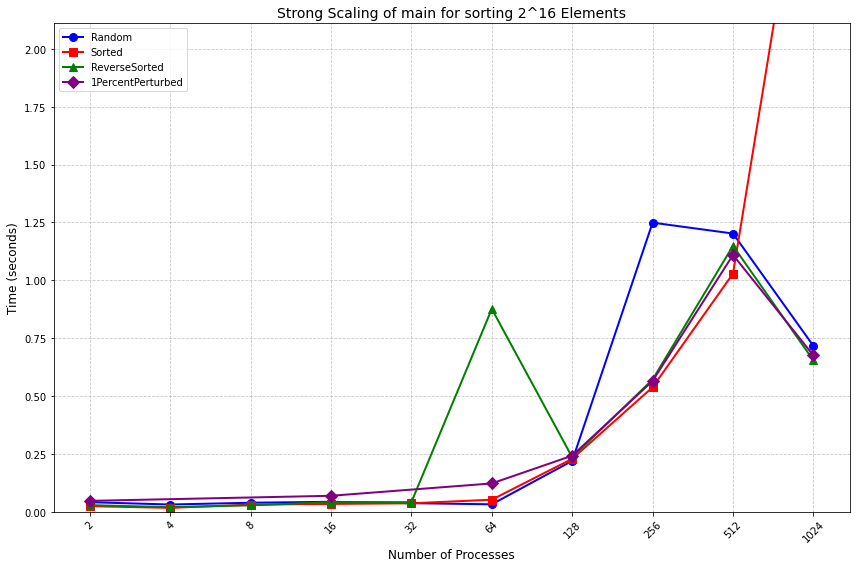

In [126]:
def plot_strong_scaling(df, processes, timing_sections, comm_type='comp_large', input_size=2**28):
    """
    Plot strong scaling graphs for computation time across different processes for a specific input size and input types.

    Parameters:
    df: pandas DataFrame with performance data
    processes: list of process counts to plot
    timing_sections: dictionary containing metric names for different timing sections
    comm_type: str, type of computation to plot ('comp_large')
    input_size: int, specific input size to filter for the plot (default: 2^28)
    """
    plt.figure(figsize=(12, 8))
    markers = ['o', 's', '^', 'D']  # Different markers for each input type
    colors = ['blue', 'red', 'green', 'purple']  # Different colors for each input type

    # Get the correct metric name from timing_sections
#     comp_metric = timing_sections['computation'][comm_type]
    comp_metric = timing_sections['whole_program']
    
    # Get unique input types
    input_types = df['input_type'].unique()
    
    # Create a dictionary to store average times
    times = {
        'avg': df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Avg time/rank']
    }
    
    for idx, input_type in enumerate(input_types):
        total_times = []
        valid_processes = []
        
        # Calculate total computation time for each process count at the specified input size
        for proc in processes:
            try:
                avg_time = times['avg'].loc[(proc, input_size, input_type, comp_metric)]
                total_times.append(avg_time)
                valid_processes.append(proc)
            except KeyError:
                print(f"Missing data for process count {proc} in {comp_metric}")
                continue
            
        # Plot line with markers if we have valid data
        if valid_processes:  
            plt.plot(valid_processes, total_times, 
                     marker=markers[idx], 
                     color=colors[idx], 
                     label=input_type,
                     linewidth=2,
                     markersize=8)

    exponent = int(math.log2(input_size))
    plt.xlabel('Number of Processes', fontsize=12)
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.title(f'Strong Scaling of main for sorting 2^{exponent} Elements', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Set x-axis to log scale with appropriate ticks
    plt.xscale('log', base=2)
    plt.xticks(processes, [str(p) for p in processes], rotation=45)
    
    # Set y-axis limits
    plt.ylim(0, max(total_times) + 1 if total_times else 10)
    
    plt.tight_layout()
    return plt

# Example usage:
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
timing_sections = {
    'whole_program': 'whole_computation',
    'initialization': 'data_init_runtime',
    'communication': {
        'main': 'comm',
        'small': 'comm_small',
        'large': 'comm_large'
    },
    'computation': {
        'main': 'comp',
        'small': 'comp_small',
        'large': 'comp_large'
    },
    'validation': 'correctness_check'
}

# # Generate the strong scaling graph for comp_large
# plt = plot_strong_scaling(combined_df, processes, timing_sections, comm_type='main', input_size=2**28)
# plt.savefig('strong_scaling_comp_large_2^28.png', bbox_inches='tight', dpi=300)
# plt.show()

# Repeat for different input sizes
input_sizes = [2**28, 2**26, 2**24, 2**22, 2**20, 2**18, 2**16]
for input_size in input_sizes:
    plt = plot_strong_scaling(combined_df, processes, timing_sections, comm_type='main', input_size=input_size)
    plt.savefig(f'strong_scaling_comp_large_{input_size}.png', bbox_inches='tight', dpi=300)
    plt.show()


Missing data for process count 2 with input size 131072 in comp_large
Missing data for process count 8 with input size 524288 in comp_large
Missing data for process count 32 with input size 2097152 in comp_large
Missing data for process count 128 with input size 8388608 in comp_large
Missing data for process count 2 with input size 131072 in comp_large
Missing data for process count 8 with input size 524288 in comp_large
Missing data for process count 32 with input size 2097152 in comp_large
Missing data for process count 64 with input size 4194304 in comp_large
Missing data for process count 128 with input size 8388608 in comp_large
Missing data for process count 2 with input size 131072 in comp_large
Missing data for process count 8 with input size 524288 in comp_large
Missing data for process count 32 with input size 2097152 in comp_large
Missing data for process count 128 with input size 8388608 in comp_large
Missing data for process count 2 with input size 131072 in comp_large
Mis

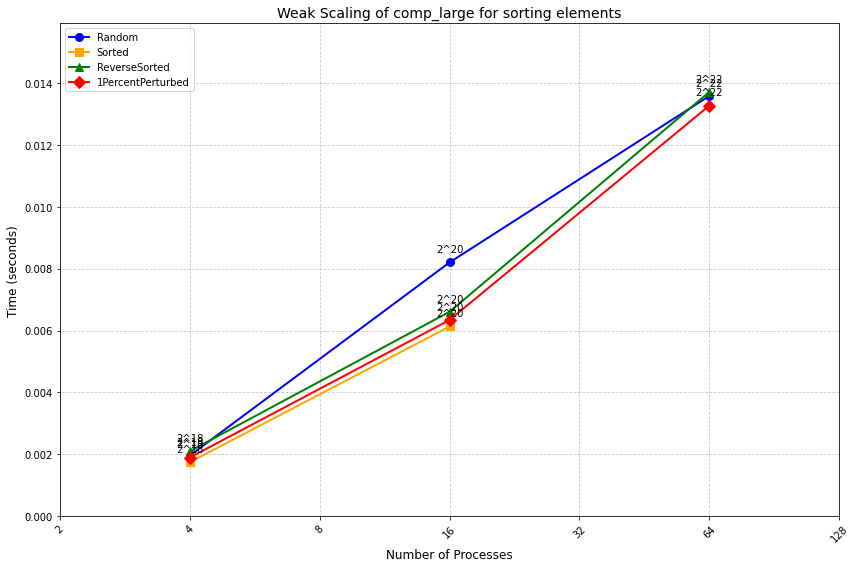

In [140]:
def plot_weak_scaling(df, processes, timing_sections, comm_type='comp_large', base_size=2**16):
    """
    Plot weak scaling graphs for computation time across different processes.
    The problem size increases proportionally with the number of processes (4:2 ratio).
    
    Parameters:
    df: pandas DataFrame with performance data
    processes: list of process counts to plot
    timing_sections: dictionary containing metric names for different timing sections
    comm_type: str, type of computation to plot
    base_size: int, base input size for the smallest number of processes
    """
    plt.figure(figsize=(12, 8))
    markers = ['o', 's', '^', 'D']  # Different markers for each input type
    colors = ['blue', 'orange', 'green', 'red']  # Different colors for each input type
    
    # Get the correct metric name from timing_sections
#     comp_metric = timing_sections['whole_program']
    comp_metric = timing_sections['computation'][comm_type]
    
    # Get unique input types
    input_types = df['input_type'].unique()
    
    # Create a dictionary to store average times
    times = {
        'avg': df.groupby(['num_procs', 'input_size', 'input_type', 'name']).min()['Avg time/rank']
    }
    
    for idx, input_type in enumerate(input_types):
        total_times = []
        valid_processes = []
        labels = []
        
        # Calculate total computation time for each process count with corresponding input size
        for proc in processes:
            # Calculate input size for this process count (4:2 ratio)
            # If processes double, input size increases by factor of 4
            scale_factor = (proc / processes[0])
            input_size = int(base_size * (scale_factor * 2))
            
            try:
                avg_time = times['avg'].loc[(proc, input_size, input_type, comp_metric)]
                total_times.append(avg_time)
                valid_processes.append(proc)
                labels.append(f'2^{int(math.log2(input_size))}')
            except KeyError:
                print(f"Missing data for process count {proc} with input size {input_size} in {comp_metric}")
                continue
        
        # Plot line with markers if we have valid data
        if valid_processes:
            plt.plot(valid_processes, total_times,
                    marker=markers[idx],
                    color=colors[idx],
                    label=input_type,
                    linewidth=2,
                    markersize=8)
            
            # Add data point labels (2^N)
            for x, y, label in zip(valid_processes, total_times, labels):
                plt.annotate(label, (x, y), textcoords="offset points", 
                           xytext=(0,10), ha='center')
    
    plt.xlabel('Number of Processes', fontsize=12)
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.title(f'Weak Scaling of comp_large for sorting elements', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Set x-axis to log scale with appropriate ticks
    plt.xscale('log', base=2)
    plt.xticks(processes, [str(p) for p in processes], rotation=45)
    
    # Set y-axis limits
    plt.ylim(0, max(total_times) * 1.2 if total_times else 10)
    
    plt.tight_layout()
    return plt

# Example usage:
processes = [2, 4, 8, 16, 32, 64, 128]
timing_sections = {
    'whole_program': 'whole_computation',
    'initialization': 'data_init_runtime',
    'communication': {
        'main': 'comm',
        'small': 'comm_small',
        'large': 'comm_large'
    },
    'computation': {
        'main': 'comp',
        'small': 'comp_small',
        'large': 'comp_large'
    },
    'validation': 'correctness_check'
}

# Generate the weak scaling graph
plt = plot_weak_scaling(combined_df, processes, timing_sections, comm_type='large', base_size=2**16)
plt.savefig('weak_scaling_plot.png', bbox_inches='tight', dpi=300)
plt.show()